# Assignment #2

# In This assignment you are asked to read a data which include 48505 articles (Documents). Then fint the most similar documents using Locality Sensitive Hashing. Follow the lecture covering this topic step by step.

## 1. Data is available in Json format and you need to read it. 'https://www.ux.uis.no/~vsetty/data/assignment2_aricles.json' (5 points)
## 2. Shingle the documents (10 points)
### Tips:
* Use string package to cleanup the articles e.g, str.maketrans('', '', string.
punctuation)
* It is better to convert text to lower case that way you get fewer n-grams
* apply ngrams(x.split(), n) using ngrams from nltk on the content + title for computing n-grams, for this data n = 2 is suffcient
  * You can use n-gram at word level for this task
  * try with different n-gram values 
  * You can use ngrams from nltk for this

## 3. Convert n-grams into binary vector representation for each document. You can do some optimzations if the matrix is too big. (10 points)
* For example,

  * Select top 10000 most frequent n-grams.
  * You may also try smaller values of n (like 2 or 3) which result in fewer n-grams.
  * Finally, you can also try sparse matrix representation. Like csr_matrix from scipy.sparse. It works even with full vocabulary.
    * Given a list of n-grams for each document, see how to builid a sparse matrix here https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

## 4. We need hash function that maps integers 0, 1, . . . , k − 1 to bucket numbers 0 through k − 1. It might be impossible to avoid collisions but as long as the collions are too many it won't matter much. (10 points)
* The simplest would be using the builtin hash() function, it can be for example, hash(rownumber) % Numberofbuckets
* You can generate several of these hash functions by xoring a random integer (hash(rownumber)^randint) % Numberofbuckets
* It can also be a as simple as (rownumber * randint) % Numberofbuckets

## 5. Compute minhash following the faster algorithm from the lecture (10 points)
## 6. Hash signature bands into buckets. Find a way to combine all the  signature values in a band and hash them into a number of buckets ususally very high. (10 points)
* Easiest way is to add all the signature values in the bucket and use a similar hash function like before
* You should use the same hash function for all bands. And all documents ending up in same bucket for at least one band are considered as candidate pairs.

## 7. Tune parameters to make sure the threshold is appropriate. (10 points)
* plot the probability of two similar items falling in same bucket for different threshold values

## 8. Choose the best parameters and get nearest neighbors of each articles (20 points)
* Jaccard Similarity
* convert hash table into dictionary of article ids and its other articles that hashed in at least 1 same bucket

## 9. Write the nearest neibhors of each document to submissions.csv (comma separated, first column is the current document followed by a list of nearest neighbors) file and get the score (10 points)

## 10. Write a report + notebook + submission file in a zip file (5 points)

In [9]:
# Step 1: Read data
import pandas as pd
import numpy as np
import json
from nltk import ngrams
import requests
import json

url = 'https://www.ux.uis.no/~vsetty/data/assignment2_aricles.json'
response = requests.get(url)
articles = json.loads(response.text)
# Json format: article_id, Title, Content



In [10]:
# Step 2: Shingle and get frequent n-grams
from collections import defaultdict
import string

# Clean text function
translator = str.maketrans('', '', string.punctuation)
def clean_text(text):
    text = text.lower()
    text = text.translate(translator)
    return text

def getFrequentNgrams(articles, n):
    top_k=10000
    shingle_counts = defaultdict(int)
    for article in articles:
        text = article['Title'] + ' ' + article['Content']
        cleaned = clean_text(text)
        words = cleaned.split()
        doc_ngrams = ngrams(words, n)  # Create n-grams
        for gram in doc_ngrams:
            shingle_counts[gram] += 1  # Count frequency
            
    sorted_shingles = sorted(shingle_counts.items(), key=lambda x: -x[1])[:top_k]
    top_shingles = [shingle for shingle, _ in sorted_shingles]  # tuple -> list
    shingle_to_index = {shingle: idx for idx, shingle in enumerate(top_shingles)} 
    return top_shingles, shingle_to_index  # most frequent shingles , lookup table for most frequent shingles

top_shingles, shingle_to_index = getFrequentNgrams(articles, n=2)

In [ ]:
# Step 3: Binary matrix
from scipy.sparse import csr_matrix

def getBinaryMatrix(articles, n):
    listOfIndices = []
    for article in articles:
        text = article['Title'] + ' ' + article['Content']
        cleaned = clean_text(text)
        words = cleaned.split()
        doc_ngrams = set(ngrams(words, n))
        indices = [shingle_to_index[gram] for gram in doc_ngrams if gram in shingle_to_index]
        listOfIndices.append(indices)
        
    data = []
    indices = []
    indptr = [0]
    for index in listOfIndices:
        indices.extend(index)
        data.extend([1] * len(index))
        indptr.append(len(indices))
    binary_matrix = csr_matrix((data, indices, indptr), shape=(len(articles), len(top_shingles)), dtype=np.int8)
    return binary_matrix

binary_matrix = getBinaryMatrix(articles, n=2)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (48505,) + inhomogeneous part.

In [ ]:
# Step 4: Hash functions
import random

def getHashFunctionValues(numrows, numhashfunctions):
    prime = 10007  # A prime larger than the number of shingles
    hash_val_matrix = np.zeros((numhashfunctions, numrows), dtype=int)
    for i in range(numhashfunctions):
        a = random.randint(1, prime-1)
        b = random.randint(0, prime-1)
        for x in range(numrows):
            hash_val = (a * x + b) % prime
            hash_val_matrix[i, x] = hash_val
    return hash_val_matrix

numhashfunctions = 100
hash_val_matrix = getHashFunctionValues(len(top_shingles), numhashfunctions)

In [ ]:
# Step 5: MinHash Signature Matrix
def getMinHashSignatureMatrix(binary_matrix, hash_val_matrix):
    numhash, numshingles = hash_val_matrix.shape
    numdocs = binary_matrix.shape[0]
    signature = np.zeros((numhash, numdocs), dtype=int)
    for doc_idx in range(numdocs):
        shingles = binary_matrix[doc_idx].indices
        if len(shingles) == 0:
            signature[:, doc_idx] = 0
        else:
            signature[:, doc_idx] = np.min(hash_val_matrix[:, shingles], axis=1)
    return signature

signature_matrix = getMinHashSignatureMatrix(binary_matrix, hash_val_matrix)


In [ ]:
# Step 6: LSH
def getLSH(signature_matrix, num_bands, num_buckets):
    numhash, numdocs = signature_matrix.shape
    band_size = numhash // num_bands
    buckets = defaultdict(list)
    for band in range(num_bands):
        start = band * band_size
        end = start + band_size
        for doc_idx in range(numdocs):
            band_sig = tuple(signature_matrix[start:end, doc_idx].flatten().tolist())
            bucket = hash(band_sig) % num_buckets
            buckets[(band, bucket)].append(doc_idx)
    return buckets

num_bands = 20
num_buckets = 1000
buckets = getLSH(signature_matrix, num_bands, num_buckets)

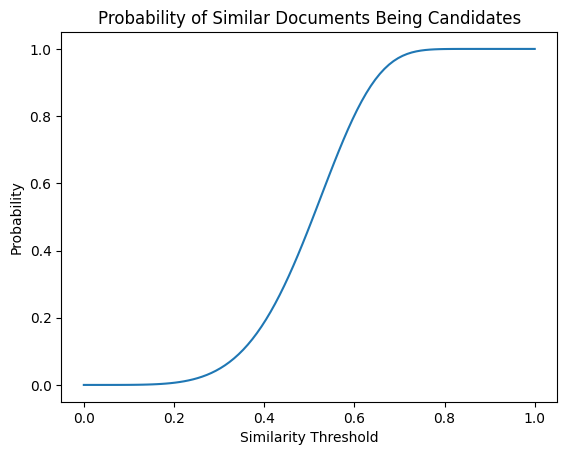

In [ ]:
# Step 7: Tune parameters (plotting example)
import matplotlib.pyplot as plt

def plotProbability(s, b, r):
    probabilities = 1 - (1 - s**r)**b
    plt.plot(s, probabilities)
    plt.xlabel('Similarity Threshold')
    plt.ylabel('Probability')
    plt.title('Probability of Similar Documents Being Candidates')
    plt.show()

s_values = np.linspace(0, 1, 100)
r = numhashfunctions // num_bands
plotProbability(s_values, num_bands, r)

# Step 8: Find nearest neighbors with Jaccard similarity
def jaccard_sorted(a, b):
    i = j = count = 0
    len_a, len_b = len(a), len(b)
    while i < len_a and j < len_b:
        if a[i] == b[j]:
            count += 1
            i += 1
            j += 1
        elif a[i] < b[j]:
            i += 1
        else:
            j += 1
    union = len_a + len_b - count
    return count / union if union else 0.0

In [ ]:
# Step 8: Find nearest neighbors with Jaccard similarity
def getJaccardSimilarityScore(a, b):
    i = j = count = 0
    len_a, len_b = len(a), len(b)
    while i < len_a and j < len_b:
        if a[i] == b[j]:
            count += 1
            i += 1
            j += 1
        elif a[i] < b[j]:
            i += 1
        else:
            j += 1
    union = len_a + len_b - count
    return count / union if union else 0.0

# Generate candidate pairs
candidate_pairs = set()
for key in buckets:
    docs = buckets[key]
    for i in range(len(docs)):
        for j in range(i+1, len(docs)):
            candidate_pairs.add(frozenset((docs[i], docs[j])))

# Precompute sorted shingle indices for each document
shingle_indices = [np.sort(binary_matrix[i].indices).tolist() for i in range(binary_matrix.shape[0])]

nearest_neighbors = defaultdict(list)
s_threshold = 0.5  # Adjust based on analysis
for pair in candidate_pairs:
    doc1, doc2 = pair
    a = shingle_indices[doc1]
    b = shingle_indices[doc2]
    similarity = getJaccardSimilarityScore(a, b)
    if similarity >= s_threshold:
        nearest_neighbors[doc1].append(doc2)
        nearest_neighbors[doc2].append(doc1)


In [ ]:
# Step 9: Write to CSV
submission_id = []
submission_nid = []
for article_id in nearest_neighbors:
    neighbors = list(set(nearest_neighbors[article_id]))
    neighbors.sort()
    submission_id.extend([article_id] * len(neighbors))
    submission_nid.extend(neighbors)

In [ ]:

data = pd.DataFrame()
data['article_id'] = submission_id
data['neighbor_id'] = submission_nid
data.sort_values(by=['article_id', 'neighbor_id'], inplace=True)
data.to_csv('submissions.csv', index=False)

In [ ]:
data.head(100)

,article_id,neighbor_id
1331251,2,7394
1223334,4,6851
1223335,4,9284
1223336,4,10196
1223337,4,13457
...,...,...
762665,12,12290
762666,12,12963
762667,12,13091
762668,12,13124


In [ ]:
# Find the article with the most similar neighbors
most_similar_article = max(nearest_neighbors, key=lambda x: len(nearest_neighbors[x]))
most_similar_neighbors = nearest_neighbors[most_similar_article]

for neighbor in most_similar_neighbors:
    print(f"Article ID: {neighbor}")
    print(f"Title: {articles[neighbor]['Title']}")
    print(f"Content: {articles[neighbor]['Content'][:200]}...\n")  # Print first 500 chars


Article ID: 36271
Title: Greenfield Daily Reporter
Content: We're sorry. There was an error. More information is provided below.

Error:

The story you are requ...

Article ID: 20598
Title: Greenfield Daily Reporter
Content: We're sorry. There was an error. More information is provided below.

Error:

The story you are requ...

Article ID: 14522
Title: Greenfield Daily Reporter
Content: We're sorry. There was an error. More information is provided below.

Error:

The story you are requ...

Article ID: 12091
Title: Greenfield Daily Reporter
Content: We're sorry. There was an error. More information is provided below.

Error:

The story you are requ...

Article ID: 31251
Title: Greenfield Daily Reporter
Content: We're sorry. There was an error. More information is provided below.

Error:

The story you are requ...

Article ID: 25724
Title: Greenfield Daily Reporter
Content: We're sorry. There was an error. More information is provided below.

Error:

The story you are requ...

Article ID